# Simple Moving Average Backtester

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from oandapyV20 import API
import oandapyV20.endpoints.instruments as instruments
from oandapyV20.exceptions import V20Error
from itertools import product
from dateutil import relativedelta
from datetime import datetime

class SMABacktester():
    def __init__(self, instrument, SMA_S, SMA_L, start, end, granularity, price, access_token, tc):
        self.instrument = instrument
        self.SMA_S = SMA_S
        self.SMA_L = SMA_L
        self.start = start
        self.end = end
        self.results = None
        self.granularity = granularity
        self.price = price
        self.access_token = '65ea0aa854d23214e7ecab3851b38115-003a1258c7194456707c1e4d45bc6d33'
        self.tc = 0.00007
        self.client = API(access_token=self.access_token)  
        self.results_overview = None
        
        self.params = {
            "granularity": self.granularity,
            "from": self.start,
            "to": self.end
        }

        # Divide the date range into monthly intervals
        start_date = datetime.strptime(self.start, '%Y-%m-%d')
        end_date = datetime.strptime(self.end, '%Y-%m-%d')
        date_ranges = []
        while start_date < end_date:
            next_month = start_date + relativedelta.relativedelta(months=1)
            if next_month > end_date:
                next_month = end_date
            date_ranges.append((start_date.strftime('%Y-%m-%d'), next_month.strftime('%Y-%m-%d')))
            start_date = next_month
        
        # Initialize an empty dataframe
        data = pd.DataFrame()

        # Loop over the monthly intervals and append the data to the dataframe
        for date_range in date_ranges:
            self.params["from"] = date_range[0]
            self.params["to"] = date_range[1]
            df = self.get_data()
            data = pd.concat([data, df])

        self.data = data
        self.prepare_data()
        self.tp_year = (self.data.price.count() / ((self.data.index[-1] - self.data.index[0]).days / 365.25)) # NEW


             
    def __repr__(self):
        return "SMABacktester(instrument = {}, SMA_S = {}, SMA_L = {}, start = {}, end = {}, granularity = {}, price = {})".format(self.instrument, self.SMA_S, self.SMA_L, self.start, self.end, self.granularity, self.price)

    def get_data(self):
        try:
              # Make API request to get pricing data
            r = instruments.InstrumentsCandles(instrument=self.instrument, params=self.params)
            response = self.client.request(r)

            # Parse the response into a Pandas DataFrame
            data = pd.DataFrame(response['candles'])
            data['time'] = pd.to_datetime(data['time'], format="%Y-%m-%dT%H:%M:%S.%f000Z")
            data.set_index('time', inplace=True)
            data.sort_index(inplace=True)
            data['c'] = data['mid'].apply(lambda x: x['c'])
            data.rename(columns={'c': 'price'}, inplace=True)
            data['price'] = pd.to_numeric(data['price'], errors='coerce')
            data.drop(columns=['complete', 'mid', 'volume'], inplace=True)
            data["returns"] = np.log(data['price']/ data['price'].shift(1))
            return data

        except V20Error as e:
            print(f"Error: {e}")
            return pd.DataFrame()
        
    def prepare_data(self):
        ''' Prepares the data for strategy backtesting
        '''
        data = self.data.copy()
        data["SMA_S"] = data["price"].rolling(self.SMA_S).mean()
        data["SMA_L"] = data["price"].rolling(self.SMA_L).mean()
        self.data = data

    def set_parameters(self, SMA_S=None, SMA_L=None):
        ''' Updates SMA parameters and the prepared dataset.
        '''
        if SMA_S is not None:
            self.SMA_S = SMA_S
            self.data["SMA_S"] = self.data["price"].rolling(self.SMA_S).mean()
        if SMA_L is not None:
            self.SMA_L = SMA_L
            self.data["SMA_L"] = self.data["price"].rolling(self.SMA_L).mean()

    def test_strategy(self):
        ''' Backtests the SMA-based trading strategy.
        '''
        self.prepare_data()
        self.run_backtest()
        self.print_performance()

    def run_backtest(self):
        ''' Runs the strategy backtest.
        '''
        data = self.data.copy().dropna()
        data["position"] = np.where(data["SMA_S"] > data["SMA_L"], 1, -1)
        data["strategy"] = data["position"].shift(1) * data["returns"]
        data.dropna(inplace=True)
        
        # Determine when a trade takes place
        data["trades"] = data["position"].diff().fillna(0).abs()
        
        # Subtract transaction costs from return when trade takes place
        data["strategy"] = data["strategy"] - data["trades"] * self.tc
        
        data["creturns"] = data["returns"].cumsum().apply(np.exp)
        data["cstrategy"] = data["strategy"].cumsum().apply(np.exp)

        self.results = data

    

    def plot_results(self):
        ''' Plots the performance of the trading strategy and compares to "buy and hold".
        '''
        if self.results is None:
            print("Run test_strategy() first.")
        else:
            title = "{} | SMA_S = {} | SMA_L = {}".format(self.instrument, self.SMA_S, self.SMA_L)
            self.results[["creturns", "cstrategy"]].plot(title=title, figsize=(12, 8))


    def optimize_parameters(self, SMA_S_range, SMA_L_range):
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))

    # test all combinations
        results = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            self.run_backtest()
            results.append(self.calculate_multiple(self.results.strategy))  # Pass the series argument

        best_perf = np.max(results)  # best performance
        opt = combinations[np.argmax(results)]  # optimal parameters

        # run/set the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.run_backtest()

        # create a df with many results
        many_results = pd.DataFrame(data=combinations, columns=["SMA_S", "SMA_L"])
        many_results["performance"] = results
        self.results_overview = many_results

        return opt, best_perf


    def optimize_strategy(self, SMA_S_range, SMA_L_range, metric="Multiple"):
        ''' Finds the optimal strategy based on a specified performance metric.

        Parameters:
        - SMA_S_range: Tuple for short-term SMA range (e.g., (10, 30))
        - SMA_L_range: Tuple for long-term SMA range (e.g., (50, 100))
        - metric: The performance metric to optimize ("Multiple", "Sharpe", "Sortino", "Calmar", "Kelly")

        Returns:
        - opt: The optimal combination of SMA_S and SMA_L values
        - best_perf: The best performance achieved according to the chosen metric
        '''

        # The metric to optimize
        if metric == "Multiple":
            performance_function = self.calculate_multiple
        elif metric == "Sharpe":
            performance_function = self.calculate_sharpe
        elif metric == "Sortino":
            performance_function = self.calculate_sortino
        elif metric == "Calmar":
            performance_function = self.calculate_calmar
        elif metric == "Kelly":
            performance_function = self.calculate_kelly_criterion
        else:
            raise ValueError("Invalid metric specified. Choose from 'Multiple', 'Sharpe', 'Sortino', 'Calmar', or 'Kelly'.")

        # Generate combinations of SMA values
        combinations = list(product(range(*SMA_S_range), range(*SMA_L_range)))

        # Test each combination
        performance = []
        for comb in combinations:
            self.set_parameters(comb[0], comb[1])
            self.run_backtest()
            # Use the chosen performance function to evaluate the strategy
            performance.append(performance_function(self.results.strategy))

        # Identify the best performance and optimal parameters
        best_perf = np.max(performance)  # Best performance
        opt = combinations[np.argmax(performance)]  # Optimal parameters

        # Set and run the optimal strategy
        self.set_parameters(opt[0], opt[1])
        self.run_backtest()

        # Create a DataFrame with all results
        many_results = pd.DataFrame(data=combinations, columns=["SMA_S", "SMA_L"])
        many_results["performance"] = performance
        self.results_overview = many_results

        self.find_best_strategy()

        return opt, best_perf


    def find_best_strategy(self):
        ''' Finds the optimal strategy (global maximum) given the SMA parameter range.
        '''
        best = self.results_overview.nlargest(1, "performance")
        SMA_S = best.SMA_S.iloc[0]
        SMA_L = best.SMA_L.iloc[0]
        perf = best.performance.iloc[0]
        print("SMA_S: {}, SMA_L: {} | {}: {}".format(SMA_S, SMA_L, self.metric, round(perf, 6))) # updated

        self.set_parameters(SMA_S, SMA_L)
        self.run_backtest()
        self.print_performance()

    
    ############################## Performance ######################################
    
    def print_performance(self):
        ''' Calculates and prints various Performance Metrics.
        '''
        
        data = self.results.copy()
        strategy_multiple = round(self.calculate_multiple(data.strategy), 6)
        bh_multiple =       round(self.calculate_multiple(data.returns), 6)
        outperf =           round(strategy_multiple - bh_multiple, 6)
        cagr =              round(self.calculate_cagr(data.strategy), 6)
        ann_mean =          round(self.calculate_annualized_mean(data.strategy), 6)
        ann_std =           round(self.calculate_annualized_std(data.strategy), 6)
        sharpe =            round(self.calculate_sharpe(data.strategy), 6)
        sortino =           round(self.calculate_sortino(data.strategy), 6)
        max_drawdown =      round(self.calculate_max_drawdown(data.strategy), 6)
        calmar =            round(self.calculate_calmar(data.strategy), 6)
        max_dd_duration =   round(self.calculate_max_dd_duration(data.strategy), 6)
        kelly_criterion =   round(self.calculate_kelly_criterion(data.strategy), 6)
        
        print(100 * "=")
        print("SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = {} | SMA_S = {} | SMA_L{}".format(self.instrument, self.SMA_S, self.SMA_L))
        print(100 * "-")
        #print("\n")
        print("PERFORMANCE MEASURES:")
        print("\n")
        print("Multiple (Strategy):         {}".format(strategy_multiple))
        print("Multiple (Buy-and-Hold):     {}".format(bh_multiple))
        print(38 * "-")
        print("Out-/Underperformance:       {}".format(outperf))
        print("\n")
        print("CAGR:                        {}".format(cagr))
        print("Annualized Mean:             {}".format(ann_mean))
        print("Annualized Std:              {}".format(ann_std))
        print("Sharpe Ratio:                {}".format(sharpe))
        print("Sortino Ratio:               {}".format(sortino))
        print("Maximum Drawdown:            {}".format(max_drawdown))
        print("Calmar Ratio:                {}".format(calmar))
        print("Max Drawdown Duration:       {} Days".format(max_dd_duration))
        print("Kelly Criterion:             {}".format(kelly_criterion))
        
        print(100 * "=")
        
    def calculate_multiple(self, series):
        return np.exp(series.sum())
    
    def calculate_cagr(self, series):
        return np.exp(series.sum())**(1/((series.index[-1] - series.index[0]).days / 365.25)) - 1
    
    def calculate_annualized_mean(self, series):
        return series.mean() * self.tp_year
    
    def calculate_annualized_std(self, series):
        return series.std() * np.sqrt(self.tp_year)
    
    def calculate_sharpe(self, series):
        if series.std() == 0:
            return np.nan
        else:
            return series.mean() / series.std() * np.sqrt(self.tp_year)
    
    def calculate_sortino(self, series):
        excess_returns = (series - 0)
        downside_deviation = np.sqrt(np.mean(np.where(excess_returns < 0, excess_returns, 0)**2))
        if downside_deviation == 0:
            return np.nan
        else:
            sortino = (series.mean() - 0) / downside_deviation * np.sqrt(self.tp_year)
            return sortino 
    
    def calculate_max_drawdown(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
        max_dd = drawdown.max()
        return max_dd
    
    def calculate_calmar(self, series):
        max_dd = self.calculate_max_drawdown(series)
        if max_dd == 0:
            return np.nan
        else:
            cagr = self.calculate_cagr(series)
            calmar = cagr / max_dd
            return calmar
    
    def calculate_max_dd_duration(self, series):
        creturns = series.cumsum().apply(np.exp)
        cummax = creturns.cummax()
        drawdown = (cummax - creturns)/cummax
    
        begin = drawdown[drawdown == 0].index
        end = begin[1:]
        end = end.append(pd.DatetimeIndex([drawdown.index[-1]]))
        periods = end - begin
        max_ddd = periods.max()
        return max_ddd.days
    
    def calculate_kelly_criterion(self, series):
        series = np.exp(series) - 1
        if series.var() == 0:
            return np.nan
        else:
            return series.mean() / series.var()
    


### Creating an instance

In [3]:
tester = SMABacktester(instrument='EUR_USD', SMA_S=50, SMA_L=200, start='2010-01-01', end='2011-01-01', granularity='M10', price='A', access_token='65ea0aa854d23214e7ecab3851b38115-003a1258c7194456707c1e4d45bc6d33', tc = 0.000059)

### Retrieving the data in our range

In [4]:
tester.get_data()

,price,returns
time,,
2010-12-01 05:00:00,1.30247,NaN
2010-12-01 05:10:00,1.30259,0.000092
2010-12-01 05:20:00,1.30239,-0.000154
2010-12-01 05:30:00,1.30158,-0.000622
2010-12-01 05:40:00,1.30191,0.000254
...,...,...
2010-12-31 21:20:00,1.33803,-0.000052
2010-12-31 21:30:00,1.33788,-0.000112
2010-12-31 21:40:00,1.33859,0.000531


### Testing the strategy

In [5]:
tester.test_strategy()

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EUR_USD | SMA_S = 50 | SMA_L200
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.119404
Multiple (Buy-and-Hold):     0.928286
--------------------------------------
Out-/Underperformance:       0.191118


CAGR:                        0.121247
Annualized Mean:             0.114438
Annualized Std:              0.118425
Sharpe Ratio:                0.966328
Sortino Ratio:               1.395065
Maximum Drawdown:            0.092779
Calmar Ratio:                1.30684
Max Drawdown Duration:       197 Days
Kelly Criterion:             8.658868


### Running the backtest and plotting the results
#### creturns = buy and hold

In [6]:
tester.run_backtest()

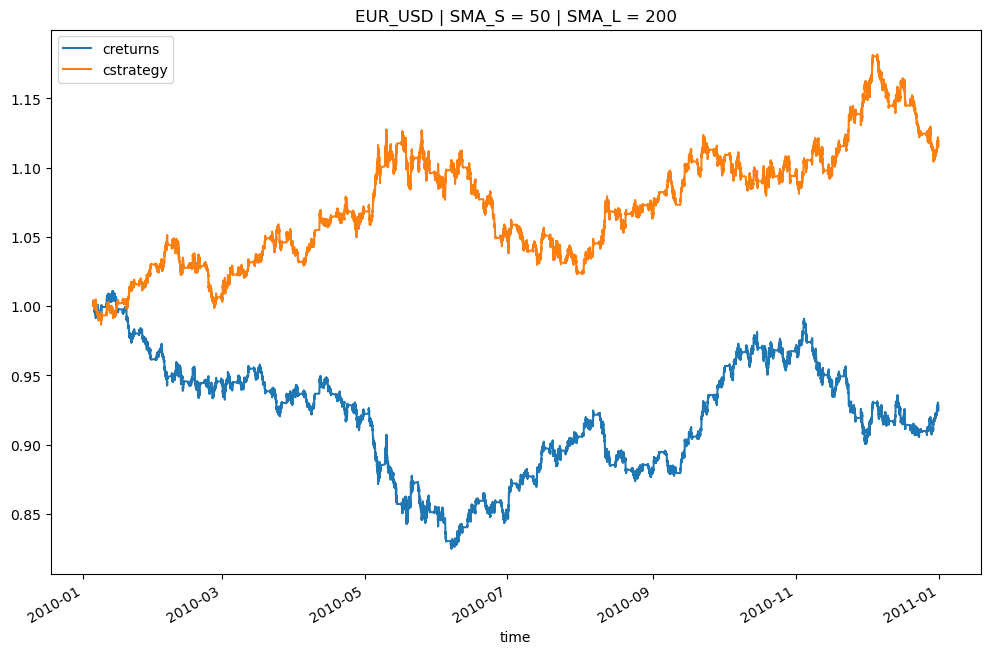

In [7]:
tester.plot_results()

### Tests for the optimal parameters

In [13]:
tester.optimize_parameters(SMA_S_range=(50,200), SMA_L_range=(75,300))

((135, 147), 1.2574202970150186)

### With the new parameters that we optimized for the performance is printed and plotted out below

In [14]:
tester.test_strategy()

SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EUR_USD | SMA_S = 135 | SMA_L147
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.25742
Multiple (Buy-and-Hold):     0.928151
--------------------------------------
Out-/Underperformance:       0.329269


CAGR:                        0.260816
Annualized Mean:             0.232072
Annualized Std:              0.118334
Sharpe Ratio:                1.961163
Sortino Ratio:               2.852858
Maximum Drawdown:            0.059868
Calmar Ratio:                4.356485
Max Drawdown Duration:       89 Days
Kelly Criterion:             17.070352


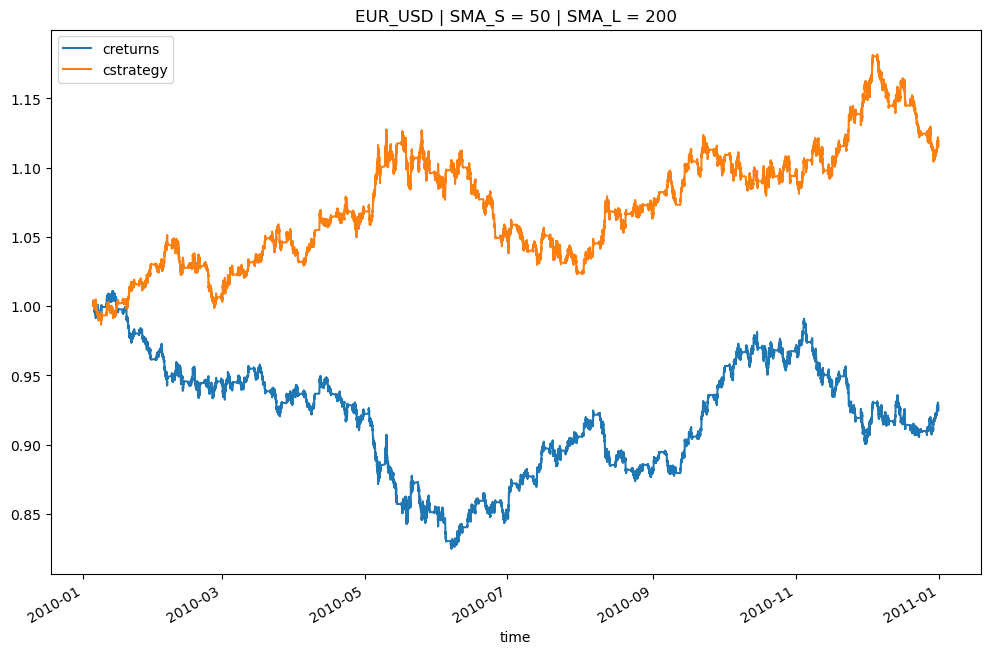

In [10]:
tester.plot_results()

### This will test combinations of short and long SMAs and return the combination that maximizes the Sharpe Ratio

In [18]:
tester.optimize_strategy((50,200), (75,300), "Sharpe")

SMA_S: 135, SMA_L: 147 | Sharpe: 1.961163
SIMPLE CONTRARIAN STRATEGY | INSTRUMENT = EUR_USD | SMA_S = 135 | SMA_L147
----------------------------------------------------------------------------------------------------
PERFORMANCE MEASURES:


Multiple (Strategy):         1.25742
Multiple (Buy-and-Hold):     0.928151
--------------------------------------
Out-/Underperformance:       0.329269


CAGR:                        0.260816
Annualized Mean:             0.232072
Annualized Std:              0.118334
Sharpe Ratio:                1.961163
Sortino Ratio:               2.852858
Maximum Drawdown:            0.059868
Calmar Ratio:                4.356485
Max Drawdown Duration:       89 Days
Kelly Criterion:             17.070352


((135, 147), 1.9611628314249534)